In [1]:
# on server: 'screen' ,then start script
# use 'strg+a d' to return to terminal
# use 'screen -r' to return to screen

import numpy as np
import json
import os

from keras.utils.data_utils import get_file
from keras.layers.embeddings import Embedding
from keras import layers
from keras.layers import recurrent
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.utils import plot_model
# os.environ['CUDA_VISIBLE_DEVICES']='0'

Using TensorFlow backend.


In [2]:
# rnn parameters
RNN = recurrent.LSTM
SENT_HIDDEN_SIZE = 100 #100 is the standard
QUERY_HIDDEN_SIZE = 100 #100 is the standard
BATCH_SIZE = 512 #for the training on the GPU this to be has to very large, otherwise the GPU is used very inefficiently
EPOCHS = 100

#glove embedding parameters
GLOVE_DIR = '../glove/glove.6B.100d.txt'
EMBEDDING_DIM = 100
EVAL_SPLIT = 0.2 

#
path='models/baseline_biderec'

In [3]:
#open SQuAD-dataset and extract the relevant data from the json-file
#to a easier readable/accessible dictionary
with open('SQuAD/train-v2.0.json') as file:
    train=json.load(file)
train_context=[]
train_question=[]
train_answer=[]
train_new={'context':train_context,'question':train_question,'answer':train_answer}
for j,data in enumerate(train['data']):
    for i,paragraph in enumerate(data['paragraphs']):
        context=paragraph['context']
        for qas in paragraph['qas']:
            #create a dataset with only the answerable questions
            if (qas['is_impossible']==False):
                train_new['context'].append(context)
                train_new['question'].append(qas['question'])
                train_new['answer'].append(qas['answers'][0]['text'])

In [4]:
#concatenate the data in one vector for preprocessing
train_all=[]
for line in train_new['context']:
    train_all.append(line)
for line in train_new['question']:
    train_all.append(line)
for line in train_new['answer']:
    train_all.append(line)

In [5]:
vocab = set()
for text in train_all:
    vocab |= set(text_to_word_sequence(text))
vocab = sorted(vocab)
vocab_size = len(vocab) + 1
print(np.shape(vocab))

(91925,)


In [6]:
#prepare the data to use as input of the rnn
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_all)
context_sequences = tokenizer.texts_to_sequences(train_new['context'])
question_sequences = tokenizer.texts_to_sequences(train_new['question'])
answer_sequences = tokenizer.texts_to_sequences(train_new['answer'])

max_len_context=max(map(len,context_sequences))
max_len_question=max(map(len,question_sequences))
max_len_answer=max(map(len,answer_sequences))

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

context = pad_sequences(context_sequences, maxlen=max_len_context)
question = pad_sequences(question_sequences, maxlen=max_len_question)
answer = pad_sequences(answer_sequences, maxlen=max_len_answer)

print('Shape of context tensor:', context.shape)
print('Shape of question tensor:', question.shape)
print('Shape of answer tensor:', answer.shape)

Found 91925 unique tokens.
Shape of context tensor: (86821, 675)
Shape of question tensor: (86821, 40)
Shape of answer tensor: (86821, 43)


In [7]:
# split the data into a training set and an evaluation set
indices = np.arange(context.shape[0])
np.random.shuffle(indices)
context = context[indices]
question = question[indices]
answer = answer[indices]
num_eval_samples = int(EVAL_SPLIT * context.shape[0])

x_train_context = context[:-num_eval_samples]
x_train_question = question[:-num_eval_samples]
y_train_answer = answer[:-num_eval_samples]

x_eval_context = context[-num_eval_samples:]
x_eval_question = question[-num_eval_samples:]
y_eval_answer = answer[-num_eval_samples:]

In [8]:
#FIX_ME: add glove download
# https://nlp.stanford.edu/projects/glove/
#get glove embeddings
embeddings_index = {}
f = open(GLOVE_DIR)#os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [9]:
#extract the glove-embedding to a matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [10]:
#create non-trainable embedding layers
# for the context and the question each
context_embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_len_context,
                            trainable=False,
                            name='context_embedding')
question_embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_len_question,
                            trainable=False,
                            name='question_embedding')

In [11]:
print('Build model...')

context_layer = layers.Input(shape=(max_len_context,), dtype='int32',name='Context_input')
encoded_context = context_embedding_layer(context_layer)
encoded_context = Bidirectional(LSTM(SENT_HIDDEN_SIZE))(encoded_context)

question_layer = layers.Input(shape=(max_len_question,), dtype='int32',name='Question_input')
encoded_question = question_embedding_layer(question_layer)
encoded_question = Bidirectional(LSTM(QUERY_HIDDEN_SIZE))(encoded_question)

merged = layers.concatenate([encoded_context, encoded_question])
preds = layers.Dense(max_len_answer, activation='softmax')(merged) #dimensions of dense layer have to to the same as the answer dimensions

model = Model([context_layer, question_layer], preds)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print('successfully built the model')
print(model.summary())

Build model...
successfully built the model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Context_input (InputLayer)      (None, 675)          0                                            
__________________________________________________________________________________________________
Question_input (InputLayer)     (None, 40)           0                                            
__________________________________________________________________________________________________
context_embedding (Embedding)   (None, 675, 100)     9192600     Context_input[0][0]              
__________________________________________________________________________________________________
question_embedding (Embedding)  (None, 40, 100)      9192600     Question_input[0][0]             
_________________________________________________________________

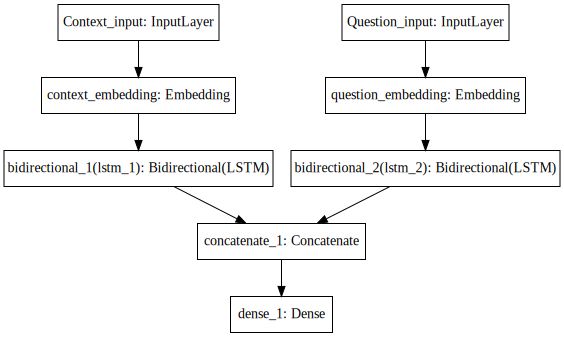

In [17]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [12]:
# print('Training')
# model.fit([x_train_context, x_train_question], y_train_answer,
#           batch_size=BATCH_SIZE,
#           epochs=EPOCHS,
#           validation_split=0.05)

# print('Evaluation')
# loss, acc = model.evaluate([x_eval_context, x_eval_question], y_eval_answer,
#                            batch_size=BATCH_SIZE)
# print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

In [14]:
print('save model')
plot_model(model, to_file=path+'/model.png')
model.save_weights('models/baseline/baseline_model.h5') #save weights
model_json = model.to_json()
with open("models/baseline/baseline_model.json",'w') as json_file:
    json_file.write(model_json)

save model
